In [5]:
import h5py
from pathlib import Path
import os
from utils.data_utils import load_dataset
from utils.w4c_dataloader import RainData
import pandas as pd
from train import DataModule
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib as mlb
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.ticker as ticker
from pathlib import Path
Path("./outputs").mkdir(parents=True, exist_ok=True)

def get_ratios(df):
    df["no_rain_ratio"] = df.no_rain / df.total
    df["rain_ratio"] = df.rain / df.total
    return df


### timestamp and splits

In [22]:
df = train_dataset.splits_df
print("shape, columns, first element: ", df.shape, df.columns, df.iloc[0,:])
print(set(df['split'].values))
df_ = df[df['split'] == 'training']
df_ = df_[df_["all_vars"] == 1]
df_.shape #20308 ==> (20308 - 32-4+1)* 3 = 60819

df_ = df[df['split'] == 'validation']
df_ = df_[df_["all_vars"] == 1]
df_.shape #2160 ==> 2160/36*3 = 180

df_ = df[df['split_type'] == 'test_in']
df_ = df_[df_["all_vars"] == 1]
df_.shape #240 ==> 240/4*3 = 180

(30720, 11) Index(['time', 'date_str', 'date', 'RATE', 'ACRR', 'DBZH', 'REFL-BT',
       'all_vars', 'split', 'split_type', 'date_time_str'],
      dtype='object') time                          000000
date_str                    20190215
date             2019-02-15 00:00:00
RATE                               1
ACRR                               1
DBZH                               1
REFL-BT                            1
all_vars                           1
split                       training
split_type                         -
date_time_str        20190215T000000
Name: 0, dtype: object
{'validation', 'heldout', 'training', 'test'}


(240, 11)

load dataset

In [47]:
import yaml

with open("models/configurations/config_34.yaml", "r") as stream:
    try:
        # print(yaml.safe_load(stream))
        config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)
print(type(config))

for band in config['dataset']['sat_bands']:
  config['dataset']['preprocess_HRIT'][band]['standardise'] = False
# config['dataset']['preprocess_OPERA'][band]['standardise'] = False
# print(config['preprocess_HRIT'])
print (config)
data = DataModule(config['dataset'], config['train'], 'train')
test_data = DataModule(config['dataset'], config['train'], 'predict')

<class 'dict'>
{'experiment': {'name': 'U-NET-252-boxy_0034', 'experiment_folder': 'lightning_logs/', 'sub_folder': 'baseline', 'precision': 32, 'logging': True}, 'dataset': {'generate_samples': False, 'sat_bands': ['IR_016', 'IR_039', 'IR_087', 'IR_097', 'IR_108', 'IR_120', 'IR_134', 'VIS006', 'VIS008', 'WV_062', 'WV_073'], 'regions': ['boxi_0034'], 'input_product': 'REFL-BT', 'output_product': 'RATE', 'out_channels': 1, 'in_channels': 11, 'swap_time_ch': True, 'full_opera_context': 1512, 'size_target_center': 252, 'len_seq_in': 4, 'len_seq_predict': 32, 'data_root': './data/2019', 'splits_path': './data/timestamps_and_splits_2019.csv', 'path_to_sample_ids': 'utils/cached_sample_ids/samples_IDs_2019_stage1_boxy_0034.pkl', 'preprocess_OPERA': {'RATE': {'rainfall_rate-500X500': {'mask': [-9999000.0, 'inf', 'nan', 'max128'], 'map': [['lessthan0.001', 0], ['greaterthan0.001', 1], [-8888000.0, 0], [-9999000.0, 0], ['inf', 0], ['nan', 0]], 'mean_std': [0.07165331, 0.6302647], 'range': [0, 1

In [48]:
from torch.utils.data import DataLoader
import torch
##input
def get_mean_std(batch_size = 1000):
    """Get the mean and stdev of the different image bands
    Args:
        times (list): timepoints to get mean from 
        batch_size (int, optional): batch size for dataloader. Defaults to 1000.
    Returns:
        mean (list): list of band means
        stdev (list): list of band stdevs
    """
    
    nimages = 0
    mean = 0
    std = 0
    count = 0
    mi = [0] *11
    ma = [0] * 11

    data = DataModule(config['dataset'], config['train'], 'train')
    test_data = DataModule(config['dataset'], config['train'], 'predict')
    for loader in [DataLoader(data.train_ds, batch_size=batch_size), DataLoader(data.val_ds, batch_size=batch_size),DataLoader(test_data.test_ds, batch_size=batch_size)]:
      for batch, _, _ in loader: #input_data, output_data, metadata
          print(count)
          count += 1
          # Rearrange batch to be the shape of [B, C, T * W * H]
          # print(batch.size())
          batch = batch.view(batch.size(0), batch.size(1), -1)
          # print(batch.size())
          # Update total number of images
          nimages += batch.size(0)

          #Compute mean of T * W * H 
          # Sum over samples
          mean += batch.mean(2).sum(0) 
          std += batch.std(2).sum(0)
          mi_ = torch.min(torch.min(batch, 2)[0], 0)[0]
          ma_ = torch.max(torch.max(batch, 2)[0], 0)[0]
          mi = [min(i, j) for i, j in zip(mi, mi_ )]
          ma = [max(i, j) for i, j in zip(ma, ma_)]
          print(mean.size(), std.size(), len(mi), len(ma))

    # Final step - divide by number of images to get average of each band
    mean /= nimages
    std /= nimages
    print(np.array(mean).shape)
    return np.array(mean),np.array(std), mi, ma


m, std, mi, ma = get_mean_std()
print(m, std, mi, ma)

load_sample_ids using pkl cache: utils/cached_sample_ids/samples_IDs_2019_stage1_boxy_0034.pkl
load_sample_ids using pkl cache: utils/cached_sample_ids/samples_IDs_2019_stage1_boxy_0034.pkl
load_sample_ids using pkl cache: utils/cached_sample_ids/samples_IDs_2019_stage1_boxy_0034.pkl
0
torch.Size([11]) torch.Size([11]) 11 11
1
torch.Size([11]) torch.Size([11]) 11 11
2
torch.Size([11]) torch.Size([11]) 11 11
3
torch.Size([11]) torch.Size([11]) 11 11
4
torch.Size([11]) torch.Size([11]) 11 11
5
torch.Size([11]) torch.Size([11]) 11 11
6
torch.Size([11]) torch.Size([11]) 11 11
7
torch.Size([11]) torch.Size([11]) 11 11
8
torch.Size([11]) torch.Size([11]) 11 11
9
torch.Size([11]) torch.Size([11]) 11 11
10
torch.Size([11]) torch.Size([11]) 11 11
11
torch.Size([11]) torch.Size([11]) 11 11
12
torch.Size([11]) torch.Size([11]) 11 11
13
torch.Size([11]) torch.Size([11]) 11 11
14
torch.Size([11]) torch.Size([11]) 11 11
15
torch.Size([11]) torch.Size([11]) 11 11
16
torch.Size([11]) torch.Size([11]) 

In [49]:
from torch.utils.data import DataLoader
import torch
##output
def get_mean_std(batch_size = 1000):
    """Get the mean and stdev of the different image bands
    Args:
        times (list): timepoints to get mean from 
        batch_size (int, optional): batch size for dataloader. Defaults to 1000.
    Returns:
        mean (list): list of band means
        stdev (list): list of band stdevs
    """
    
    nimages = 0
    mean = 0
    std = 0
    count = 0
    mi = [0] *11
    ma = [0] * 11

    data = DataModule(config['dataset'], config['train'], 'train')
    test_data = DataModule(config['dataset'], config['train'], 'predict')
    for loader in [DataLoader(data.train_ds, batch_size=batch_size), DataLoader(data.val_ds, batch_size=batch_size),DataLoader(test_data.test_ds, batch_size=batch_size)]:
      for _, output_data, metadata in loader: #input_data, output_data, metadata
          if count >=21:
            break
          print(count)
          count += 1
          # Rearrange batch to be the shape of [B, C, T * W * H]
          # if count==1: print(metadata, "| ", output_data.size())
          # print(np.array(output_data).shape) #[1000, 1, 32, 252, 252]
          batch = output_data.view(output_data.size(0), output_data.size(1), -1)
          print(batch.size())
          # Update total number of images
          nimages += batch.size(0)

          #Compute mean of T * W * H 
          # Sum over samples
          mean += batch.mean(2).sum(0)
          std += batch.std(2).sum(0)
          mi_ = torch.min(torch.min(batch, 2)[0], 0)[0]
          ma_ = torch.max(torch.max(batch, 2)[0], 0)[0]
          mi = [min(i, j) for i, j in zip(mi, mi_ )]
          ma = [max(i, j) for i, j in zip(ma, ma_)]
          print(mean.size(), std.size(), len(mi), len(ma))

    # Final step - divide by number of images to get average of each band
    mean /= nimages
    std /= nimages
    print(np.array(mean).shape)
    return np.array(mean),np.array(std), mi, ma

m, std, mi, ma = get_mean_std()
print(m, std, mi, ma)

load_sample_ids using pkl cache: utils/cached_sample_ids/samples_IDs_2019_stage1_boxy_0034.pkl
load_sample_ids using pkl cache: utils/cached_sample_ids/samples_IDs_2019_stage1_boxy_0034.pkl
load_sample_ids using pkl cache: utils/cached_sample_ids/samples_IDs_2019_stage1_boxy_0034.pkl
0
torch.Size([1000, 1, 2032128])
torch.Size([1]) torch.Size([1]) 1 1
1
torch.Size([1000, 1, 2032128])
torch.Size([1]) torch.Size([1]) 1 1
2
torch.Size([1000, 1, 2032128])
torch.Size([1]) torch.Size([1]) 1 1
3
torch.Size([1000, 1, 2032128])
torch.Size([1]) torch.Size([1]) 1 1
4
torch.Size([1000, 1, 2032128])
torch.Size([1]) torch.Size([1]) 1 1
5
torch.Size([1000, 1, 2032128])
torch.Size([1]) torch.Size([1]) 1 1
6
torch.Size([1000, 1, 2032128])
torch.Size([1]) torch.Size([1]) 1 1
7
torch.Size([1000, 1, 2032128])
torch.Size([1]) torch.Size([1]) 1 1
8
torch.Size([1000, 1, 2032128])
torch.Size([1]) torch.Size([1]) 1 1
9
torch.Size([1000, 1, 2032128])
torch.Size([1]) torch.Size([1]) 1 1
10
torch.Size([1000, 1, 2

In [4]:

train_dataset = data.train_ds
val_dataset = data.val_ds
# test_dataset = test_data.test_ds
with open('./train_dataset.txt', 'w') as f:
  f.write(str(vars(train_dataset)))
print(train_dataset.__len__(), val_dataset.__len__())
input_data, output_data, metadata = train_dataset.__getitem__(60818)


60819 180


In [5]:
print(input_data.shape, output_data.shape)
print(np.count_nonzero(output_data))


(11, 4, 252, 252) (1, 32, 252, 252)
1807


### Visualize Rain or Not for one datapoint

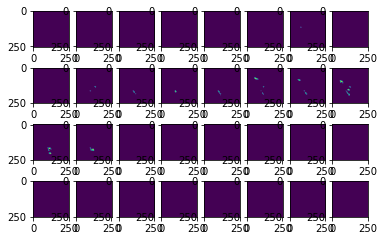

In [29]:
fig = plt.figure()
for i in range(output_data.shape[1]):
  sub = fig.add_subplot(4, 8, i+1)
  sub.imshow(output_data[0][i,:,:])
plt.show()

### Rain or Not rain wrt Time

In [18]:
di = {"timestamp": [], "total": [], "rain": [], "no_rain": []}
total, no_rain_cnt, rain_cnt = 0, 0, 0
for i in tqdm(range(train_dataset.__len__())):
  input_data, output_data, metadata = train_dataset.__getitem__(i)
  # output_data (1,32,252, 252)
  # get first element from prediction sequence
  output_data = output_data[0][0]
  total += (~np.isnan(output_data)).sum()
  no_rain_cnt += (output_data == 0).sum()
  rain_cnt += (output_data == 1).sum()
  assert total == no_rain_cnt + rain_cnt
  
  input_timestamp = metadata['input']['timestamps']
  output_timestamp = metadata['target']['timestamps']
  assert len(output_timestamp) == 32
  # get first element from output_timestamp
  head = output_timestamp[0]
  
  di['timestamp'].append(head)
  di["total"].append( (~np.isnan(output_data)).sum())
  di["no_rain"].append((output_data == 0).sum())
  di["rain"].append( (output_data == 1).sum())

last = train_dataset.__len__()-1
input_data, output_data, metadata = train_dataset.__getitem__(last)
# output_data (1,32,252, 252)
# get second to last element from prediction sequence
output_data = output_data[0][1:]
total += (~np.isnan(output_data)).sum()
no_rain_cnt += (output_data == 0).sum()
rain_cnt += (output_data == 1).sum()
assert total == no_rain_cnt + rain_cnt

input_timestamp = metadata['input']['timestamps']
output_timestamp = metadata['target']['timestamps']
assert len(output_timestamp) == 32
# get second to last element from output_timestamp
for t_i, t in enumerate(output_timestamp[1:]):
  di['timestamp'].append(t)
  di["total"].append( (~np.isnan(output_data[t_i, :, :])).sum())
  di["no_rain"].append((output_data[t_i, :, :] == 0).sum())
  di["rain"].append( (output_data[t_i, :, :] == 1).sum())


print(total, no_rain_cnt, rain_cnt) #3864218400 3224531356 639687044
temporal_df = pd.DataFrame(di)
temporal_df.to_csv("./outputs/rain_per_timestamp_train.csv", index=True)


100%|██████████| 60819/60819 [1:11:15<00:00, 14.23it/s]


3864218400 3224531356 639687044


### Rain or Not ratio for entire dataset

In [19]:
no_rain_cnt/total, rain_cnt/total

(0.8344588794463584, 0.1655411205536416)

### Map timestamp (sample idxs) to date

In [29]:
## map timestamp to date
def timestamp_mapper(df, data_split='training', len_seq_in=4, len_seq_predict=32):
  map = {}
  idxs = []
  df_ = df[df['split'] == data_split]
  df_ = df_[df_['all_vars'] == 1]
  print(df_.shape[0])##must be 20308
  # non testing
  for i in range(df_.shape[0]):
    map[i] = df_.iloc[i,:]['date']
  return map

train_mapper = timestamp_mapper(df, "training")
# val_mapper = timestamp_mapper(temporal_df, "validation")

20308


In [30]:
## add datetime column to temporal_df
temporal_df['datetime'] = temporal_df['timestamp'].apply(lambda row: train_mapper[row])


In [31]:
temporal_df.head()

,timestamp,total,rain,no_rain,datetime
0,4,63504,0,63504,2019-02-15
1,5,63504,0,63504,2019-02-15
2,6,63504,0,63504,2019-02-15
3,7,63504,0,63504,2019-02-15
4,8,63504,0,63504,2019-02-15


In [32]:
temporal_df.to_csv("./outputs/rain_per_timestamp_train.csv")

In [67]:
temporal_df = pd.read_csv("./outputs/rain_per_timestamp_train.csv")

### Rain rate per 15min 

In [69]:
stats_by_time = temporal_df.groupby('timestamp', as_index=False).aggregate('sum')
stats_by_time = get_ratios(stats_by_time)
stats_by_time.reset_index()
stats_by_time.shape, stats_by_time.head()

((20304, 7),
    timestamp  Unnamed: 0   total  rain  no_rain  no_rain_ratio  rain_ratio
 0          4       60819  190512     0   190512            1.0         0.0
 1          5       60822  190512     0   190512            1.0         0.0
 2          6       60825  190512     0   190512            1.0         0.0
 3          7       60828  190512     0   190512            1.0         0.0
 4          8       60831  190512     0   190512            1.0         0.0)

In [74]:
## draw ratio per timestamp
figure = mlb.figure.Figure(figsize=(72, 4))
ax1 = figure.subplots()
# color = "tab:blue"
ax1.plot(stats_by_time.timestamp, stats_by_time.rain_ratio, label="Rain")
ax1.set_xlabel('Date')
ax1.set_ylabel('Ratio')

ax1.legend()

for label in ax1.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

ax1.grid(which="major", axis="x", linestyle="-")
ax1.grid(which="minor", axis="x", linestyle=":")

# ax1.grid(axis="x", linestyle="--")
# ax1.grid(which="minor", axis="x", linestyle="--")

figure.tight_layout(pad=0.5)
figure.savefig("precipitation_ratio_by_timestamp.pdf")

figure

<Figure size 7200x400 with 1 Axes>

### Rain rates per month (datetime)

In [73]:
stats_by_datetime = temporal_df.groupby('datetime', as_index=False).aggregate('sum')
stats_by_datetime = get_ratios(stats_by_datetime)
stats_by_datetime.reset_index()
stats_by_datetime.shape, stats_by_datetime.head()

((319, 8),
      datetime  Unnamed: 0  timestamp     total    rain   no_rain  \
 0  2019-02-15     5607906      13662  17527104    3093  17524011   
 1  2019-02-16     5878800      41328  18289152   15196  18273956   
 2  2019-02-17     5104998      58017  15812496   41057  15771439   
 3  2019-02-18     1356597      18843   4191264  934348   3256916   
 4  2019-02-19     2903049      45120   8954064  933097   8020967   
 
    no_rain_ratio  rain_ratio  
 0       0.999824    0.000176  
 1       0.999169    0.000831  
 2       0.997404    0.002596  
 3       0.777073    0.222927  
 4       0.895791    0.104209  )

In [87]:
## draw ratio per timestamp
figure = mlb.figure.Figure(figsize=(72, 4))
ax1 = figure.subplots()
# color = "tab:blue"
ax1.plot(stats_by_datetime.datetime, stats_by_datetime.rain_ratio, label="Rain")
ax1.set_xlabel('Date')
ax1.set_ylabel('Ratio')

ax1.xaxis.set_minor_locator(ticker.MaxNLocator(4))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))


ax1.legend()

for label in ax1.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

ax1.grid(which="major", axis="x", linestyle="-")
ax1.grid(which="minor", axis="x", linestyle=":")

# ax1.grid(axis="x", linestyle="--")
# ax1.grid(which="minor", axis="x", linestyle="--")

figure.tight_layout(pad=0.5)
figure.savefig("./outputs/precipitation_ratio_by_datetime.pdf")

figure

<Figure size 7200x400 with 1 Axes>

In [5]:
arr = np.array([[0,1,2,],[3,4,5],[6,7,8]])
arr = arr.flatten()
arr

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

### pointwise rain rate

In [3]:
import yaml

with open("models/configurations/config_baseline.yaml", "r") as stream:
    try:
        # print(yaml.safe_load(stream))
        config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)
print (config)

{'experiment': {'name': 'U-NET-252', 'experiment_folder': 'lightning_logs/', 'sub_folder': 'baseline', 'precision': 32, 'logging': True}, 'dataset': {'generate_samples': True, 'sat_bands': ['IR_016', 'IR_039', 'IR_087', 'IR_097', 'IR_108', 'IR_120', 'IR_134', 'VIS006', 'VIS008', 'WV_062', 'WV_073'], 'regions': ['boxi_0015', 'boxi_0034', 'boxi_0076'], 'input_product': 'REFL-BT', 'output_product': 'RATE', 'out_channels': 1, 'in_channels': 11, 'swap_time_ch': True, 'full_opera_context': 1512, 'size_target_center': 252, 'len_seq_in': 4, 'len_seq_predict': 32, 'data_root': 'data/2019', 'splits_path': 'data/timestamps_and_splits_2019.csv', 'path_to_sample_ids': 'utils/cached_sample_ids/samples_IDs_2019_stage1.pkl', 'preprocess_OPERA': {'RATE': {'rainfall_rate-500X500': {'mask': [-9999000.0, 'inf', 'nan', 'max128'], 'map': [['lessthan0', 0], ['greaterthan0', 1], [-8888000.0, 0], [-9999000.0, 0], ['inf', 0], ['nan', 0]], 'mean_std': [0.07165331, 0.6302647], 'range': [0, 128], 'standardise': Fa

In [28]:
di = {"region": [], "point":[], "total": [], "rain": [], "no_rain": []}
regions = ['boxi_0015', 'boxi_0034', 'boxi_0076']
from operator import add
# >>> list( map(add, list1, list2) )
# [5, 7, 9]
# reload data module for separate region
for r in regions:
  config['dataset']['regions'] = [r]
  data = DataModule(config['dataset'], config['train'], 'train')
  train_data = data.train_ds
  print ("region {} : dataset size {}".format(r, train_data.__len__()))
  di["region"] = [r for _ in range(252*252)]
  di["point"] = range(252*252)

  total, no_rain_cnt, rain_cnt = [0 for _ in range(252*252)], [0 for _ in range(252*252)], [0 for _ in range(252*252)]
  # for i in tqdm(range(train_data.__len__())):
  for i in tqdm(range(500)):
    input_data, output_data, metadata = train_data.__getitem__(i)
    # output_data size (1,32,252, 252)

    # get first element from prediction sequence
    output_data = output_data[0][0]
    # print((~np.isnan(output_data)).flatten())
    total = list(map (add, total, (~np.isnan(output_data)).flatten()))
    no_rain_cnt = list(map (add, no_rain_cnt, list((output_data == 0).flatten())))
    rain_cnt = list(map (add, rain_cnt, list((output_data == 1).flatten())))
    
  last = train_data.__len__()-1
  input_data, output_data, metadata = train_data.__getitem__(last)
  # output_data (1,32,252, 252)
  # get second to last element from prediction sequence
  output_data = output_data[0][1:]
  for each_out in output_data:
    total = list(map (add, total, (~np.isnan(output_data)).flatten()))
    no_rain_cnt = list(map (add, no_rain_cnt, list((output_data == 0).flatten())))
    rain_cnt = list(map (add, rain_cnt, list((output_data == 1).flatten())))


  di['total'] = total
  di['rain'] = rain_cnt
  di['no_rain'] = no_rain_cnt
  print( set(rain_cnt))
  pointwise_df = pd.DataFrame(di)
  pointwise_df.to_csv("./outputs/rain_pointwise_{}.csv".format(r), index=True)

region boxi_0015 : dataset size 20273


100%|██████████| 500/500 [00:41<00:00, 12.04it/s]


{7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57}
region boxi_0034 : dataset size 20273


100%|██████████| 500/500 [00:41<00:00, 12.07it/s]


{40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 140, 141, 142, 145, 146, 149, 150, 152, 153, 154, 156, 157, 162, 163, 164, 174}
region boxi_0076 : dataset size 20273


100%|██████████| 500/500 [00:40<00:00, 12.37it/s]


{0}


In [38]:
print(len(total))

63504


In [53]:

for r in regions:
  df = pd.read_csv("./outputs/rain_pointwise_{}.csv".format(r))
  # pointwise_df = df.groupby('point').aggregate('sum')
  pointwise_df = get_ratios(df)

  ## draw ratio pointwise
  arr = np.array(pointwise_df['rain_ratio']).reshape(252, 252)
  plt.imshow(arr)
  # plt.show()
  heatmap = plt.pcolor(arr)
  plt.colorbar(heatmap)

  plt.tight_layout(pad=0.5)
  plt.savefig("./outputs/precipitation_ratio_pointwise_{}.pdf".format(r))
  plt.clf()  
  plt.close()
